# Advanced processing

The pynapple package provides a small set of high-level functions that are widely used in system neuroscience.
- [Discrete correlograms](https://peyrachelab.github.io/pynapple/process.correlograms/)
- [Tuning curves](https://peyrachelab.github.io/pynapple/process.tuning_curves/)
- [Decoding](https://peyrachelab.github.io/pynapple/process.decoding/)

This notebook provides few examples with artificial data.

In [1]:
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt

## Discrete correlograms

The main function to compute cross-correlogram is [*cross_correlogram*](https://peyrachelab.github.io/pynapple/process.correlograms/#pynapple.process.correlograms.cross_correlogram).


The function is compiled with [numba](https://numba.pydata.org/) to increase performances. This means it accepts only pure numpy array as argument.

Text(0, 0.5, 'CC')

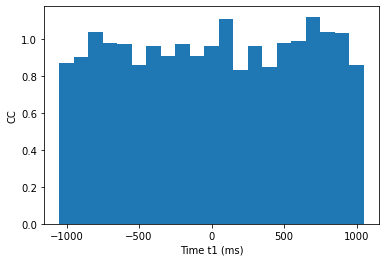

In [2]:
ts1 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')
ts2 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')

ts1_time_array = ts1.as_units('ms').index.values
ts2_time_array = ts2.as_units('ms').index.values

binsize = 100 # ms
cc12, xt = nap.cross_correlogram(t1 = ts1_time_array,
                                 t2 = ts2_time_array,
                                 binsize=binsize,
                                 windowsize=1000 # ms
                                )

plt.figure()
plt.bar(xt, cc12, binsize)
plt.xlabel("Time t1 (ms)")
plt.ylabel("CC")


Since it's a bit tedious to convert to a numpy.ndarray, pynapple provides wrappers for computing autocorrelogram and crosscorrelogram for TsGroup. The function is then called for each unit or each pairs of units. It returns directly a pandas.DataFrame holding all the correlograms. In this example, autocorrelograms and cross-correlograms are computed for the same TsGroup.

In [3]:
epoch = nap.IntervalSet(start = 0, end = 1000, time_units = 's')
ts_group = nap.TsGroup({0:ts1,1:ts2}, time_support = epoch)

autocorrs = nap.compute_autocorrelogram(group=ts_group, 
                                        ep=epoch,
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                       )
crosscorrs = nap.compute_crosscorrelogram(group=ts_group,
                                        ep=epoch,
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                       )

print(autocorrs, '\n')
print(crosscorrs, '\n')


            0     1
-1000.0  1.09   1.0
-900.0   1.03  0.91
-800.0   0.98  1.18
-700.0   1.04  1.03
-600.0   0.99  1.15
-500.0   0.92  0.86
-400.0   1.14  1.04
-300.0   1.17  1.17
-200.0   0.96  0.99
-100.0   1.12  0.98
 0.0      0.0   0.0
 100.0   1.12  0.98
 200.0   0.96  0.99
 300.0   1.17  1.17
 400.0   1.14  1.04
 500.0   0.92  0.86
 600.0   0.99  1.15
 700.0   1.04  1.03
 800.0   0.98  1.18
 900.0   1.03  0.91
 1000.0  1.09   1.0 

            0
            1
-1000.0  0.87
-900.0   0.90
-800.0   1.04
-700.0   0.98
-600.0   0.97
-500.0   0.86
-400.0   0.96
-300.0   0.91
-200.0   0.97
-100.0   0.91
 0.0     0.96
 100.0   1.11
 200.0   0.83
 300.0   0.96
 400.0   0.85
 500.0   0.98
 600.0   0.99
 700.0   1.12
 800.0   1.04
 900.0   1.03
 1000.0  0.86 



## Tuning curves

For now, pynapple can compute 1 dimension tuning curves (for example firing rate as a function of angular direction) and 2 dimension tuning curves ( for example firing rate as a function of position). In both cases, a TsGroup object can be directly passed to the function.

                 a         b
Time (s)                    
0.1       0.995004  0.099833
0.2       0.980067  0.198669
0.3       0.955336  0.295520
0.4       0.921061  0.389418
0.5       0.877583  0.479426
...            ...       ...
999.5     0.889961  0.456036
999.6     0.839987  0.542606
999.7     0.781621  0.623754
999.8     0.715445  0.698670
999.9     0.642120  0.766604

[9999 rows x 2 columns]


/home/guillaume/pynapple/pynapple/process/tuning_curves.py:117: RuntimeWarning: invalid value encountered in true_divide
  count = count / occupancy


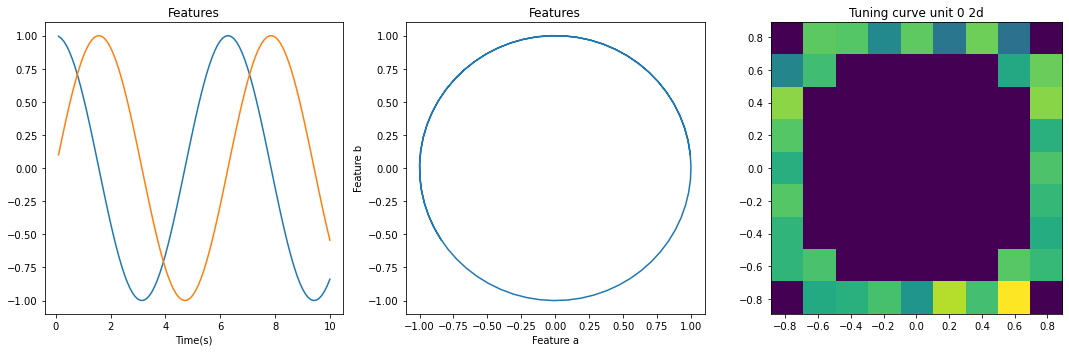

In [4]:
features = np.vstack((np.cos(np.arange(0, 1000, 0.1)),np.sin(np.arange(0,1000,0.1)))).T
features = nap.TsdFrame(t = np.arange(0, 1000, 0.1), d = features, time_units = 's', time_support = epoch, columns=['a', 'b'])

print(features)

tcurves1d = nap.compute_1d_tuning_curves(group=ts_group,
                                         feature = features['a'],
                                         ep = epoch,
                                         nb_bins=10)


tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,
                                                 feature = features,
                                                 ep = epoch,
                                                 nb_bins=10)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features.as_units('s').loc[0:10])
plt.title("Features")
plt.xlabel("Time(s)")
plt.subplot(132)
plt.title("Features")
plt.plot(features['a'].as_units('s').loc[0:10], features['b'].as_units('s').loc[0:10])
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.subplot(133)
plt.title("Tuning curve unit 0 2d")
plt.imshow(tcurves2d[0], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
plt.tight_layout()
plt.show()

## Decoding

Pynapple supports 1 dimension and 2 dimension bayesian decoding. The function returns the decoded feature as well as the probabilities for each timestamps.

First let's generate some fake "place fields" in 2 dimensions based on the features.

/home/guillaume/pynapple/pynapple/process/tuning_curves.py:117: RuntimeWarning: invalid value encountered in true_divide
  count = count / occupancy


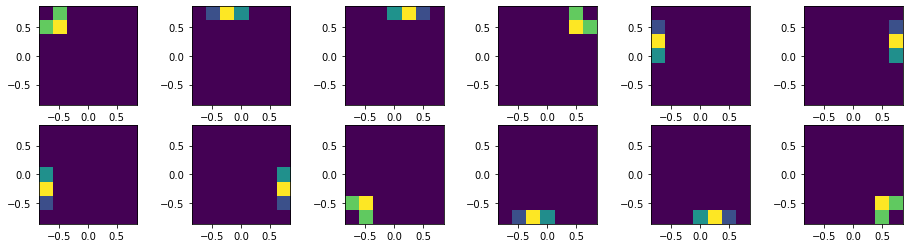

In [5]:
#############################################################################################
# This part is just to generate units with a relationship to the features (i.e. "place fields")
times = features.index.values
ft = features.values

bounds=np.arange(-1.0, 1.0, 0.5)
ts_group = {}
count = 0
for x in bounds:
    for y in bounds:        
        tidx = times[(ft[:,0]>x) & (ft[:,0]<x+0.5) & (ft[:,1]>y) & (ft[:,1]<y+0.5)]        
        if len(tidx):
            ts_group[count] = nap.Ts(t=np.unique(tidx))
            count += 1
ts_group = nap.TsGroup(ts_group, time_support = epoch)
##############################################################################################

tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,feature = features,ep = epoch,nb_bins=8)

plt.figure(figsize = (16,4))
for i in ts_group.keys():
    plt.subplot(2,6,i+1)
    plt.imshow(tcurves2d[i], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
    plt.xticks()
plt.show()

Then we can call the actual decoding function in 2d.

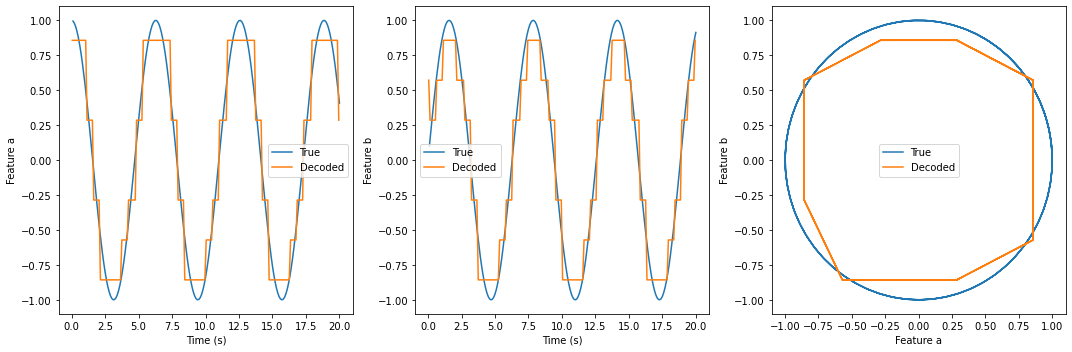

In [6]:
decoded, proba_feature = nap.decode_2d(tuning_curves=tcurves2d, 
                                     group=ts_group, 
                                     feature=features, 
                                     ep=epoch,
                                     bin_size=0.1, # second
                                     xy=binsxy
                                    )


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features['a'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature a")
plt.subplot(132)
plt.plot(features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature b")
plt.subplot(133)
plt.plot(features['a'].as_units('s').loc[0:20], features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.legend()
plt.tight_layout()
plt.show()